In [199]:
import numpy as np
import tensorflow as tf
from qa_model import AttentionQA
from data import QALoader, tokenize
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [200]:
batch_size = 100
vocab_path = os.path.join('./data', 'vocab.json')
test = QALoader(os.path.join('./data', 'test.txt'), vocab_path, batch_size, 45, 6)

Pre-processing data...
Pre-processed 2000 lines of data.


In [201]:
tf.reset_default_graph()
m = AttentionQA(is_training=False)

save_dir = './models/'
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())
ckpt = tf.train.get_checkpoint_state(save_dir)
saver.restore(sess, ckpt.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ./models/ptr_net.ckpt


In [202]:
x_batch, x_lengths, q_batch, q_lengths, label = test.next_batch()

In [203]:
train_dict = {m.encoder_inputs: x_batch,
              m.input_lengths: x_lengths,
              m.question_inputs: q_batch,
              m.question_lengths: q_lengths}
pointers,prob,hprob,q_aligned = sess.run([m.pointers, m.qa_alignment, m.hqa_alignment, m.question_alignment], feed_dict=train_dict)
pointers = pointers[0]

In [204]:
classify = []
mis_classify = []
for i in range(100):
    ans = test.labels[i]
    if ans[0] == pointers[i]:
        classify.append(i)
    else:
        mis_classify.append(i)

In [222]:
for i in mis_classify[:10]:
    text = test.text[i]
    question = test.q_text[i]
    ans = test.labels[i]
    print(text)
    print('Question: {}'.format(question))
    print('Answer: {}'.format(tokenize(text)[ans[0]]))
    print('Pred: {} \n'.format(tokenize(text)[pointers[i]]))

a cat reluctantly went nowhere. a football player went to the classroom. a dog went to the station suddenly ten minutes ago.
Question: where is the cat ?
Answer: nowhere
Pred: station 

a cat quickly went to the morgue. a dog reluctantly went to japan.
Question: where is the cat ?
Answer: morgue
Pred: japan 

a cat quickly went to canada earlier. a dog went to the kitchen. a cat slowly went home ten minutes ago.
Question: where is the dog ?
Answer: kitchen
Pred: home 

a dog went to the classroom suddenly five minutes ago. a cat suddenly went to japan.
Question: where is the dog ?
Answer: classroom
Pred: japan 



In [223]:
for i in classify[:3]:
    text = test.text[i]
    question = test.q_text[i]
    ans = test.labels[i]
    print(text)
    print('Question: {}'.format(question))
    print('Answer: {}'.format(tokenize(text)[ans[0]]))
    print('Pred: {} \n'.format(tokenize(text)[pointers[i]]))

a dog went nowhere happily yesterday. a football player went nowhere.
Question: where is the football player ?
Answer: nowhere
Pred: nowhere 

a teacher slowly went home. a dog slowly went to canada. a football player suddenly went to canada.
Question: where is the dog ?
Answer: canada
Pred: canada 

a dog suddenly went home.
Question: where is the dog ?
Answer: home
Pred: home 



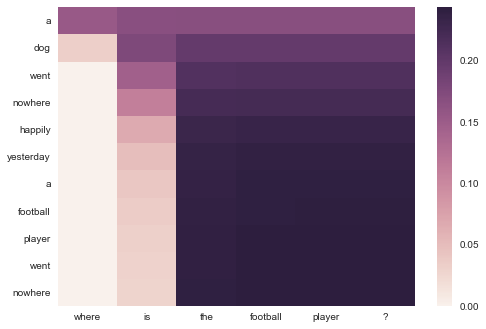

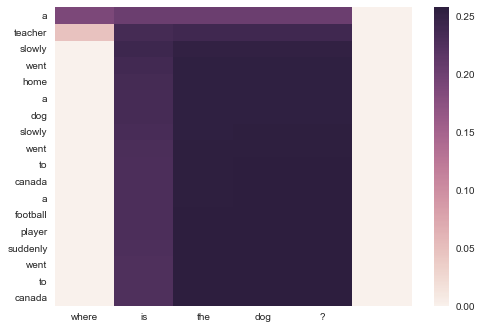

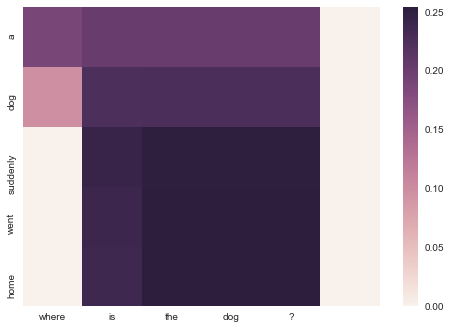

In [207]:
for i in classify[:3]:
    sns.heatmap(prob[i][:len(tokenize(test.text[i]))], yticklabels = tokenize(test.text[i]), xticklabels = tokenize(test.q_text[i]))
    plt.show()

In [208]:
# for i in mis_classify[:3]:
#     sns.heatmap(prob[i][:len(tokenize(test.text[i]))], yticklabels = tokenize(test.text[i]), xticklabels = tokenize(test.q_text[i]))
#     plt.show()

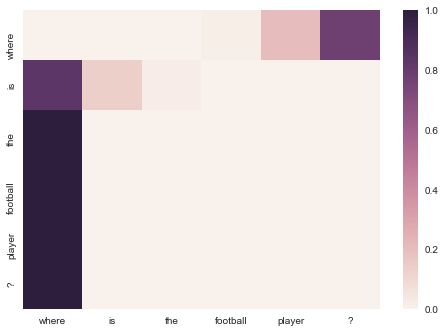

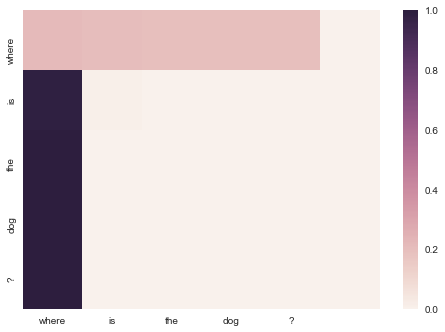

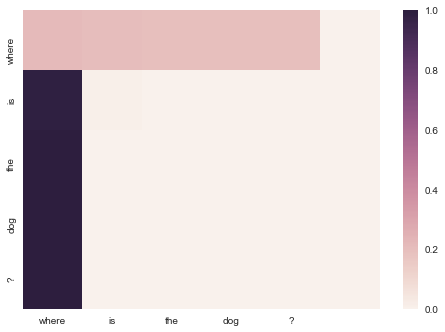

In [209]:
for i in classify[:3]:
    sns.heatmap(q_aligned[i][:len(tokenize(test.q_text[i]))], yticklabels = tokenize(test.q_text[i]), xticklabels = tokenize(test.q_text[i]))
    plt.show()

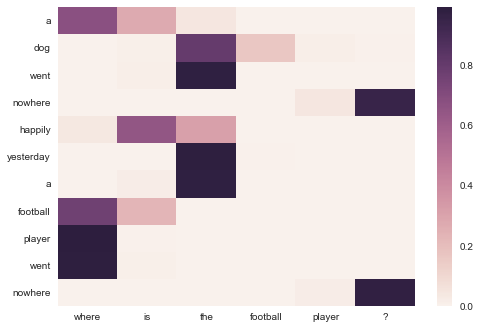

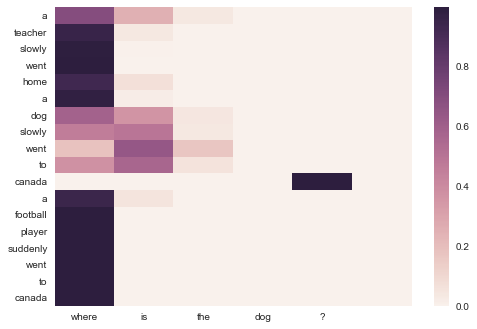

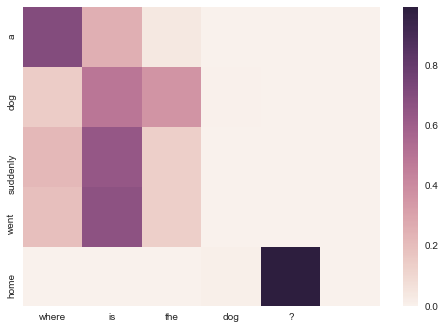

In [210]:
for i in classify[:3]:
    sns.heatmap(hprob[i][:len(tokenize(test.text[i]))], yticklabels = tokenize(test.text[i]), xticklabels = tokenize(test.q_text[i]))
    plt.show()

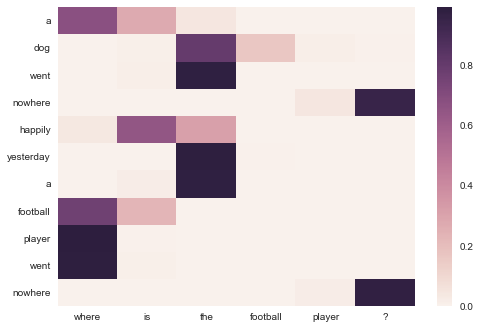

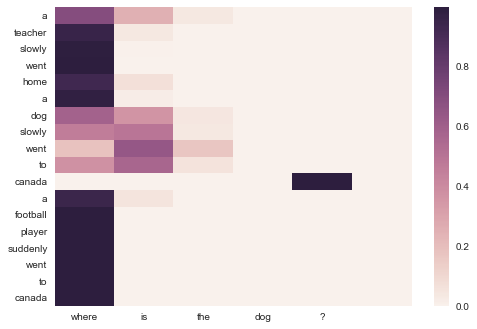

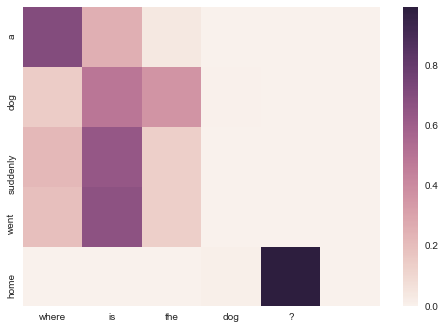

In [211]:
for i in classify[:3]:
    sns.heatmap(hprob[i][:len(tokenize(test.text[i]))], yticklabels = tokenize(test.text[i]), xticklabels = tokenize(test.q_text[i]))
    plt.show()

In [253]:
def process_text(txt, loader, length):
    txt = txt.lower()
    txt = txt.replace('.', '')
    tokens = txt.split(' ')
    lengths = len(tokens)
    def convert(word):
        if word not in loader.vocab.keys():
            return 0
        else:
            return loader.vocab[word]
    embedding = list(map(convert, tokens)) + [0] * (length- len(tokens))
    return embedding, lengths

In [254]:
def build_batch(s, q, loader):
    emb_s, s_l = process_text(s, loader, loader.seq_length )
    emb_q, q_l = process_text(q, loader, loader.q_length )
    x_batch = np.array([emb_s] * batch_size)
    q_batch = np.array([emb_q] * batch_size)
    x_length = np.array([s_l] * batch_size)
    q_length = np.array([q_l] * batch_size)
    return x_batch, x_length, q_batch, q_length

In [255]:
def ask(s, q, loader, m):
    s = s.lower()
    s = s.replace('.', '')
    s_tokens = s.split(' ')
    q = q.lower()
    q = q.replace('.', '')
    q_tokens = q.split(' ')
    batch = build_batch(s, q, loader)
    feed_dict = {m.encoder_inputs:batch[0],
                 m.input_lengths: batch[1],
                 m.question_inputs: batch[2],
                 m.question_lengths: batch[3]}
    pointers,prob,hprob,q_aligned = sess.run([m.pointers, m.qa_alignment, m.hqa_alignment, m.question_alignment], feed_dict=feed_dict)
    print('A: {}'.format(s_tokens[pointers[0][0]]))

In [271]:
s = 'Yuji went to canada reluctantly. a student went to school. Yuji went home.'
q = 'Where is Yuji ?'

In [272]:
ask(s, q, test, m)

A: canada
